In [1]:
import time
import numpy as np
import os
os.chdir("../")  # 更改notebook的工作路径到上一级目录
os.getcwd()

In [2]:
import torch
import cv2
import torch.nn as nn
from torchvision import transforms

from dataset.VOC_dataset import VOCDataset
from model.loss import GenTargets, LOSS, coords_fmap2orig
from model.fcos import FCOS, DetectHead, ClipBoxes
import matplotlib.patches as patches
import matplotlib.pyplot as plt

#from matplotlib.ticker import NullLocator
#from model.fcos import FCOSDetector
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

## 图像处理

In [3]:
def preprocess_img(image, input_ksize):
    """
    resize image and bboxes
    Returns
    image_paded: input_ksize
    bboxes: [None,4]
    """
    min_side, max_side = input_ksize
    h, w, _ = image.shape

    smallest_side = min(w, h)
    largest_side = max(w, h)
    scale = min_side / smallest_side
    if largest_side * scale > max_side:
        scale = max_side / largest_side
    nw, nh = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))

    pad_w = 32 - nw % 32
    pad_h = 32 - nh % 32

    image_paded = np.zeros(shape=[nh + pad_h, nw + pad_w, 3], dtype=np.uint8)
    image_paded[:nh, :nw, :] = image_resized
    return image_paded

In [4]:
def draw_result(img, boxes, classes, scores):  
    plt.figure(figsize=(10,10))
    ax = plt.gca()  # get current axis
    
    for i, box in enumerate(boxes):
        pt1 = (int(box[0]), int(box[1]))
        pt2 = (int(box[2]), int(box[3]))
        
        b_color = colors[int(classes[i]) - 1]  # color map
        
        bbox = patches.Rectangle((box[0], box[1]), width=box[2] - box[0], height=box[3] - box[1], 
                                 linewidth=1,
                                 facecolor='none', 
                                 edgecolor=b_color)
        ax.add_patch(bbox)
        
        ax.text(box[0], box[1], s="%s %.3f" % (VOCDataset.CLASSES_NAME[int(classes[i])], scores[i]), 
                color='white',
                verticalalignment='top',
                bbox={'color': b_color, 'pad': 0})
        
    plt.axis('off')
    plt.imshow(img)
    plt.show()

## 模型加载

In [5]:
class Config():
    # backbone
    pretrained = False
    freeze_stage_1 = True
    freeze_bn = True

    # fpn
    fpn_out_channels = 256
    use_p5 = True

    # head
    class_num = 80
    use_GN_head = True
    prior = 0.01
    add_centerness = True
    cnt_on_reg = False

    # training
    strides = [8, 16, 32, 64, 128]
    limit_range = [[-1, 64], [64, 128], [128, 256], [256, 512], [512, 999999]]

    # inference
    score_threshold = 0.3
    nms_iou_threshold = 0.4
    max_detection_boxes_num = 300

In [6]:
class FCOSDetector(nn.Module):
    def __init__(self, config=None):
        super().__init__()
        if config is None:
            config = DefaultConfig

        self.fcos_body = FCOS(config=config)
        
        self.detection_head = DetectHead(config.score_threshold, config.nms_iou_threshold,
                                         config.max_detection_boxes_num, config.strides, config)
        self.clip_boxes = ClipBoxes()

    def forward(self, inputs):
        """
        FCOS网络 for inference mode, img should preprocessed before feeding in net 
        :param inputs:
                [inference] img
        :return:
                [inference] scores, classes, boxes
        """
        batch_imgs = inputs
        out = self.fcos_body(batch_imgs)
        scores, classes, boxes = self.detection_head(out)
        boxes = self.clip_boxes(batch_imgs, boxes)
        return scores, classes, boxes

In [7]:
model = FCOSDetector(config=Config)

model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load("./checkpoint/voc_77.8.pth", map_location=torch.device('cpu')))

model = model.eval()
print("===>success loading model")

INFO===>success frozen BN
INFO===>success frozen backbone stage1
===>success loading model


## 模型推断

In [8]:
#计算时间函数  带返回参数的装饰器
def exe_time(func):  
    def wrapper(*args, **kw):  
        local_time = time.time()  
        res = func(*args, **kw) 
        print('success processing img, cost time: %.2f  ms' % ((time.time() - local_time)*1000)) 
        return res
    return wrapper 

In [9]:
@exe_time
def model_inference(img_path):
    # 读入图像并处理
    img_bgr = cv2.imread(img_path)
    img_pad = preprocess_img(img_bgr, [800, 1333])
    img = cv2.cvtColor(img_pad.copy(), cv2.COLOR_BGR2RGB)
    img_in = transforms.ToTensor()(img)
    img_in = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225], inplace=True)(img_in)
    img_in = img_in.unsqueeze_(dim=0)  # 增加批次维度
    # 模型推断
    with torch.no_grad():
        out = model(img_in)
    scores, classes, boxes = out
    
    boxes = boxes[0].cpu().numpy().tolist()
    classes = classes[0].cpu().numpy().tolist()
    scores = scores[0].cpu().numpy().tolist()
    return boxes, classes, scores, img

success processing img, cost time: 8157.04  ms


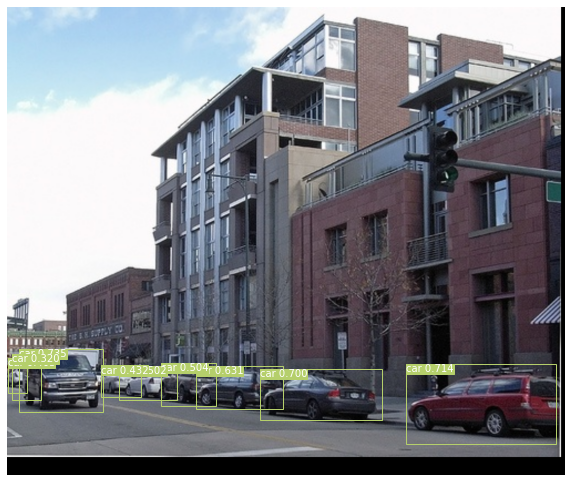

success processing img, cost time: 338.10  ms


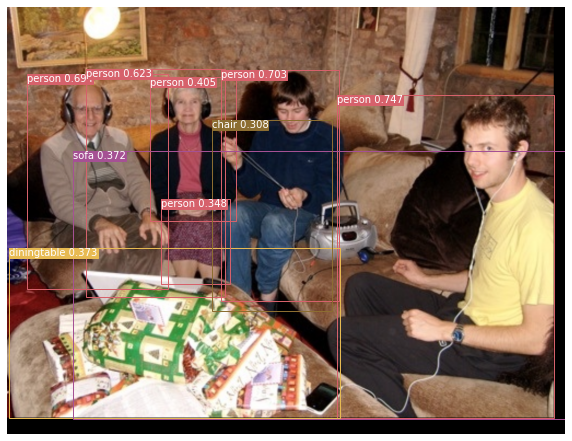

In [10]:
# root = "./notebooks/dataset/VOCdevkit/VOC2012/JPEGImages/"
root = "./test_images/"
names = os.listdir(root)

for name in names:
    img_path = root + name  # python中字符串支持直接相加
    boxes, classes, scores, img = model_inference(img_path)
    draw_result(img, boxes, classes, scores)

===>success processing img, cost time 1427.31 ms


<Figure size 432x288 with 0 Axes>

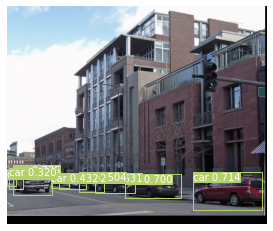

===>success processing img, cost time 265.29 ms


<Figure size 432x288 with 0 Axes>

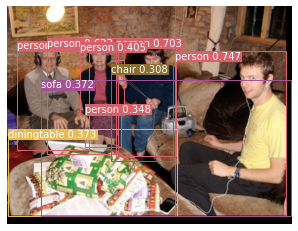

In [6]:
# root = "./notebooks/dataset/VOCdevkit/VOC2012/JPEGImages/"
root = "./test_images/"
names = os.listdir(root)
for name in names:
    
    img_bgr = cv2.imread(root + name)
    img_pad = preprocess_img(img_bgr, [800, 1333])
    img = cv2.cvtColor(img_pad.copy(), cv2.COLOR_BGR2RGB)
    img1 = transforms.ToTensor()(img)
    img1 = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225], inplace=True)(img1)
    # img1 = img1

    start_t = time.time()
    with torch.no_grad():
        out = model(img1.unsqueeze_(dim=0))
    end_t = time.time()
    cost_t = 1000 * (end_t - start_t)
    print("===>success processing img, cost time %.2f ms" % cost_t)
    # print(out)
    scores, classes, boxes = out

    boxes = boxes[0].cpu().numpy().tolist()
    classes = classes[0].cpu().numpy().tolist()
    scores = scores[0].cpu().numpy().tolist()
    plt.figure()
    fig, ax = plt.subplots(1)
    # ax.imshow(img)
    
    for i, box in enumerate(boxes):
        pt1 = (int(box[0]), int(box[1]))
        pt2 = (int(box[2]), int(box[3]))
        # img_pad = cv2.rectangle(img_pad, pt1, pt2, (0, 255, 0))
        b_color = colors[int(classes[i]) - 1]
        bbox = patches.Rectangle((box[0], box[1]), width=box[2] - box[0], height=box[3] - box[1], linewidth=1,
                                 facecolor='none', edgecolor=b_color)
        ax.add_patch(bbox)
        plt.text(box[0], box[1], s="%s %.3f" % (VOCDataset.CLASSES_NAME[int(classes[i])], scores[i]), color='white',
                 verticalalignment='top',
                 bbox={'color': b_color, 'pad': 0})
    plt.axis('off')
    #plt.gca().xaxis.set_major_locator(NullLocator())
    #plt.gca().yaxis.set_major_locator(NullLocator())
    #plt.savefig('out_images/{}'.format(name), bbox_inches='tight', pad_inches=0.0)
    #plt.close()
    plt.imshow(img)
    plt.show()

## 推断细节

In [11]:
class DetectHead(nn.Module):
    def __init__(self, score_threshold, nms_iou_threshold, max_detection_boxes_num, strides, config=None):
        super().__init__()
        self.score_threshold = score_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detection_boxes_num = max_detection_boxes_num
        self.strides = strides
        if config is None:
            self.config = DefaultConfig
        else:
            self.config = config

    def forward(self, inputs):
        '''
        inputs  list [cls_logits,cnt_logits,reg_preds]  
        cls_logits  list contains five [batch_size,class_num,h,w]  
        cnt_logits  list contains five [batch_size,1,h,w]  
        reg_preds   list contains five [batch_size,4,h,w] 
        '''
        cls_logits, coords = self._reshape_cat_out(inputs[0], self.strides)  # [batch_size,sum(_h*_w),class_num]
        cnt_logits, _ = self._reshape_cat_out(inputs[1], self.strides)  # [batch_size,sum(_h*_w),1]
        reg_preds, _ = self._reshape_cat_out(inputs[2], self.strides)  # [batch_size,sum(_h*_w),4]

        cls_preds = cls_logits.sigmoid_()
        cnt_preds = cnt_logits.sigmoid_()

        coords = coords.cuda() if torch.cuda.is_available() else coords

        cls_scores, cls_classes = torch.max(cls_preds, dim=-1)  # [batch_size,sum(_h*_w)]
        if self.config.add_centerness:
            cls_scores = torch.sqrt(cls_scores * (cnt_preds.squeeze(dim=-1)))  # [batch_size,sum(_h*_w)]
        cls_classes = cls_classes + 1  # [batch_size,sum(_h*_w)]

        boxes = self._coords2boxes(coords, reg_preds)  # [batch_size,sum(_h*_w),4]

        # select topk
        max_num = min(self.max_detection_boxes_num, cls_scores.shape[-1])
        topk_ind = torch.topk(cls_scores, max_num, dim=-1, largest=True, sorted=True)[1]  # [batch_size,max_num]
        _cls_scores = []
        _cls_classes = []
        _boxes = []
        for batch in range(cls_scores.shape[0]):
            _cls_scores.append(cls_scores[batch][topk_ind[batch]])  # [max_num]
            _cls_classes.append(cls_classes[batch][topk_ind[batch]])  # [max_num]
            _boxes.append(boxes[batch][topk_ind[batch]])  # [max_num,4]
        cls_scores_topk = torch.stack(_cls_scores, dim=0)  # [batch_size,max_num]
        cls_classes_topk = torch.stack(_cls_classes, dim=0)  # [batch_size,max_num]
        boxes_topk = torch.stack(_boxes, dim=0)  # [batch_size,max_num,4]
        assert boxes_topk.shape[-1] == 4
        return self._post_process([cls_scores_topk, cls_classes_topk, boxes_topk])

    def _post_process(self, preds_topk):
        '''
        cls_scores_topk [batch_size,max_num]
        cls_classes_topk [batch_size,max_num]
        boxes_topk [batch_size,max_num,4]
        '''
        _cls_scores_post = []
        _cls_classes_post = []
        _boxes_post = []
        cls_scores_topk, cls_classes_topk, boxes_topk = preds_topk
        for batch in range(cls_classes_topk.shape[0]):
            mask = cls_scores_topk[batch] >= self.score_threshold
            _cls_scores_b = cls_scores_topk[batch][mask]  # [?]
            _cls_classes_b = cls_classes_topk[batch][mask]  # [?]
            _boxes_b = boxes_topk[batch][mask]  # [?,4]
            nms_ind = self.batched_nms(_boxes_b, _cls_scores_b, _cls_classes_b, self.nms_iou_threshold)
            _cls_scores_post.append(_cls_scores_b[nms_ind])
            _cls_classes_post.append(_cls_classes_b[nms_ind])
            _boxes_post.append(_boxes_b[nms_ind])
        scores, classes, boxes = torch.stack(_cls_scores_post, dim=0), torch.stack(_cls_classes_post,
                                                                                   dim=0), torch.stack(_boxes_post,
                                                                                                       dim=0)

        return scores, classes, boxes

    @staticmethod
    def box_nms(boxes, scores, thr):
        '''
        boxes: [?,4]
        scores: [?]
        '''
        if boxes.shape[0] == 0:
            return torch.zeros(0, device=boxes.device).long()
        assert boxes.shape[-1] == 4
        x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
        areas = (x2 - x1 + 1) * (y2 - y1 + 1)
        order = scores.sort(0, descending=True)[1]
        keep = []
        while order.numel() > 0:
            if order.numel() == 1:
                i = order.item()
                keep.append(i)
                break
            else:
                i = order[0].item()
                keep.append(i)

            xmin = x1[order[1:]].clamp(min=float(x1[i]))
            ymin = y1[order[1:]].clamp(min=float(y1[i]))
            xmax = x2[order[1:]].clamp(max=float(x2[i]))
            ymax = y2[order[1:]].clamp(max=float(y2[i]))
            inter = (xmax - xmin).clamp(min=0) * (ymax - ymin).clamp(min=0)
            iou = inter / (areas[i] + areas[order[1:]] - inter)
            idx = (iou <= thr).nonzero().squeeze()
            if idx.numel() == 0:
                break
            order = order[idx + 1]
        return torch.LongTensor(keep)

    def batched_nms(self, boxes, scores, idxs, iou_threshold):

        if boxes.numel() == 0:
            return torch.empty((0,), dtype=torch.int64, device=boxes.device)
        # strategy: in order to perform NMS independently per class.
        # we add an offset to all the boxes. The offset is dependent
        # only on the class idx, and is large enough so that boxes
        # from different classes do not overlap
        max_coordinate = boxes.max()
        offsets = idxs.to(boxes) * (max_coordinate + 1)
        boxes_for_nms = boxes + offsets[:, None]
        keep = self.box_nms(boxes_for_nms, scores, iou_threshold)
        return keep

    def _coords2boxes(self, coords, offsets):
        '''
        Args
        coords [sum(_h*_w),2]
        offsets [batch_size,sum(_h*_w),4] ltrb
        '''
        x1y1 = coords[None, :, :] - offsets[..., :2]
        x2y2 = coords[None, :, :] + offsets[..., 2:]  # [batch_size,sum(_h*_w),2]
        boxes = torch.cat([x1y1, x2y2], dim=-1)  # [batch_size,sum(_h*_w),4]
        return boxes

    def _reshape_cat_out(self, inputs, strides):
        '''
        Args
        inputs: list contains five [batch_size,c,_h,_w]
        Returns
        out [batch_size,sum(_h*_w),c]
        coords [sum(_h*_w),2]
        '''
        batch_size = inputs[0].shape[0]
        c = inputs[0].shape[1]
        out = []
        coords = []
        for pred, stride in zip(inputs, strides):
            pred = pred.permute(0, 2, 3, 1)
            coord = coords_fmap2orig(pred, stride).to(device=pred.device)
            pred = torch.reshape(pred, [batch_size, -1, c])
            out.append(pred)
            coords.append(coord)
        return torch.cat(out, dim=1), torch.cat(coords, dim=0)

In [12]:
class ClipBoxes(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, batch_imgs, batch_boxes):
        batch_boxes = batch_boxes.clamp_(min=0)
        h, w = batch_imgs.shape[2:]
        batch_boxes[..., [0, 2]] = batch_boxes[..., [0, 2]].clamp_(max=w - 1)
        batch_boxes[..., [1, 3]] = batch_boxes[..., [1, 3]].clamp_(max=h - 1)
        return batch_boxes

In [13]:
class FCOSDetector(nn.Module):
    def __init__(self, config=None):
        super().__init__()
        if config is None:
            config = DefaultConfig

        self.fcos_body = FCOS(config=config)
        
        self.detection_head = DetectHead(config.score_threshold, config.nms_iou_threshold,
                                         config.max_detection_boxes_num, config.strides, config)
        self.clip_boxes = ClipBoxes()

    def forward(self, inputs):
        """
        FCOS网络 for inference mode, img should preprocessed before feeding in net 
        :param inputs:
                [inference] img
        :return:
                [inference] scores, classes, boxes
        """
        batch_imgs = inputs
        out = self.fcos_body(batch_imgs)
        scores, classes, boxes = self.detection_head(out)
        boxes = self.clip_boxes(batch_imgs, boxes)
        return scores, classes, boxes